# Medium article trend analysis by POS 

Trend analysis scripts used to see 

## Initialization

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hiron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hiron\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



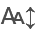

In [121]:
import re
from datetime import date,timedelta
import time
import csv
import os

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import random

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from collections import Counter
    
import multiprocessing
from multiprocessing import Manager
import importlib 

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
#PARAMETERS

SOURCE_FOLDER = 'data/'
FILE_PREFIX = 'articles_'
POS_FILTER = set(['CC','DT','IN','JJ','JJR','JJS','MD','PDT','PRP','PRP$','RB','RBR','RBS','RP','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WRB'])

## Files import

In [45]:
files = os.listdir(None if SOURCE_FOLDER == ''  else SOURCE_FOLDER)

In [46]:
target_sources = []
source_df = None
for file in files:
    if file.startswith(FILE_PREFIX):
        target_sources.append(file)
for source in target_sources:
    if source_df is None:
        source_df = pd.read_csv(SOURCE_FOLDER + source)
    else/:
        s.ource_df = pd.concat([source_df,pd.read_csv(SOURCE_FOLDER + source)], axis=0)
source_df = source_df.reset_index()

In [48]:
source_df.head(2)

index                                                url           tag  \
0      0  https://medium.com/@Classy/using-data-science-...  data-science   
1      1  https://medium.com/@tenaciouscb/new-year-new-u...  data-science   

         date                                            content  
0  2016-01-01  Classy\nFollow\n4\nListen\nShare\nMore\nBy Edw...  
1  2016-01-01  Chrissie Brodigan\nFollow\n9\nListen\nShare\nM...

## POS Tagging

In [78]:
%%time
import workers

importlib.reload(workers)
    
articles_stats = pd.DataFrame(columns=['url','year','month','sentence count','word count'])
monthly_word_stats = pd.DataFrame(columns=['year','month','word','pos','word count'])

dates = source_df['date'].unique()
year_months = set([string[:7] for string in dates])

# The following loop runs a script in pythons.py in a multi-process manner to reduce runtime. The processed values are aggregated per month as monthly word 
# stats, with separate output for article-level stats
if __name__ == '__main__':
    pool = multiprocessing.Pool()
    for year_month in year_months:
        monthly_word_counter = Counter([("","")])
        year_month_articles = source_df.loc[source_df['date'].str.contains(year_month),:]
        results = pool.map(workers.count_words,[(row,POS_FILTER) for index, row in year_month_articles.iterrows()])
        for word_counter, article_stats in results:
            monthly_word_counter += word_counter
            articles_stats = pd.concat([articles_stats,article_stats],axis=0)
        words = []
        for key, value in monthly_word_counter.items():
            words.append([key[0],key[1],value])
        words_df = pd.DataFrame(words)
        words_df = words_df.rename({0:'word',1:'pos',2:'word count'},axis=1)
        words_df['year'] = year_month[:4]
        words_df['month'] = year_month[5:7]
        monthly_word_stats = pd.concat([monthly_word_stats,words_df],axis=0)
    pool.close()


CPU times: total: 55 s
Wall time: 5min


In [91]:
monthly_word_stats.to_csv('monthly_word_stats.csv')
articles_stats.to_csv('articles_stats.csv')

In [92]:
monthly_word_df = monthly_word_stats
monthly_word_df['year-month'] = monthly_word_df['year'] + '-' + monthly_word_df['month']

## Top 1000 articles analysis

In [203]:
# Chagne the following variable to analyze different POS types
# For list of POS tags, see https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk
pos_filter = 'JJ'

top_1000_words = monthly_word_df.loc[monthly_word_df['pos'].str.contains(pos_filter),:].groupby('word')['word count'].sum().sort_values(ascending=False).head(1000).index.to_list()


In [204]:
top_1000_words_df = monthly_word_df.loc[monthly_word_df['word'].isin(top_1000_words) & (monthly_word_df['pos'].str.contains(pos_filter)),:]

top_1000_words_df = top_1000_words_df.pivot_table(index='word', columns=['year'], values='word count', aggfunc = 'sum')
top_1000_words_df.sort_values(by='2023',ascending=False).head(1000)
top_1000_words_df = top_1000_words_df.fillna(0)

In [210]:
agg_funcs = {'sentence count': 'sum', 'word count': 'sum', 'url': 'count'}

yearly_stats_df = articles_stats.groupby('year')[['sentence count','word count','url']].agg(agg_funcs)

yearly_stats_df['word per sentence'] = yearly_stats_df['word count'] / yearly_stats_df['sentence count']

In [211]:
yearly_stats_df

sentence count word count   url word per sentence
year                                                  
2016          70053    1785182  2009         25.483305
2017          91496    2292506  2613         25.055806
2018         135528    3431841  3639         25.322007
2019         105905    2655151  2846         25.071064
2020         172210    4214932  3658         24.475536
2021         156695    3827329  3648         24.425342
2022         138426    3374029  3644         24.374243
2023         130565    3162714  3644         24.223291

In [212]:
articles_per_year = yearly_stats_df['url'].tolist()

In [213]:
top_1000_words_pct_df = top_1000_words_df / articles_per_year

In [214]:
# Adding original scoring to make the most intersting changes show on the top between 2022 & 2023
# The scoring  [diff of the two values] ^2 / [avg of the two values]
top_1000_words_pct_df['score'] = 2 * (top_1000_words_pct_df['2023'] - top_1000_words_pct_df['2022']) * (top_1000_words_pct_df['2023'] - top_1000_words_pct_df['2022']) / (top_1000_words_pct_df['2022'] + top_1000_words_pct_df['2023'])

#Result for easier viewing in a dataframe
def convert_to_percentage(row):
    return '{:+.2f}%'.format((row['2023'] / row['2022'] - 1.0) * 100 )

top_1000_words_pct_df['% relative change'] = top_1000_words_pct_df.apply(convert_to_percentage,axis=1)
top_1000_words_pct_df.sort_values(by='score',ascending=False)


year            2016      2017      2018      2019      2020      2021  \
word                                                                     
crucial     0.042807  0.057023  0.051937  0.071328  0.071077  0.075384   
ethical     0.019910  0.022197  0.035174  0.025650  0.017769  0.026590   
potential   0.132404  0.135476  0.124485  0.110330  0.126572  0.114857   
essential   0.055749  0.057405  0.056059  0.062895  0.098688  0.105537   
powerful    0.127924  0.123995  0.122836  0.120871  0.134226  0.126645   
...              ...       ...       ...       ...       ...       ...   
political   0.093081  0.058936  0.060181  0.046732  0.050027  0.022752   
curious     0.035341  0.025258  0.028854  0.029515  0.035812  0.036732   
unfamiliar  0.003484  0.009950  0.008794  0.009487  0.011482  0.009046   
conceptual  0.004978  0.009568  0.008519  0.011595  0.013942  0.008224   
excellent   0.057242  0.034443  0.044518  0.056219  0.055768  0.049342   

year            2022      2023     score % relative change  
word                                                        
crucial     0.078485  0.337541  0.322624          +330.07%  
ethical     0.014270  0.137212  0.199558          +861.54%  
potential   0.118277  0.310922  0.172937          +162.88%  
essential   0.108397  0.294457  0.171864          +171.65%  
powerful    0.128430  0.321350  0.165494          +150.21%  
...              ...       ...       ...               ...  
political   0.017014  0.017014  0.000000            +0.00%  
curious     0.027442  0.027442  0.000000            +0.00%  
unfamiliar  0.007958  0.007958  0.000000            +0.00%  
conceptual  0.008782  0.008782  0.000000            +0.00%  
excellent   0.052415  0.052415  0.000000            +0.00%  

[1000 rows x 10 columns]

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


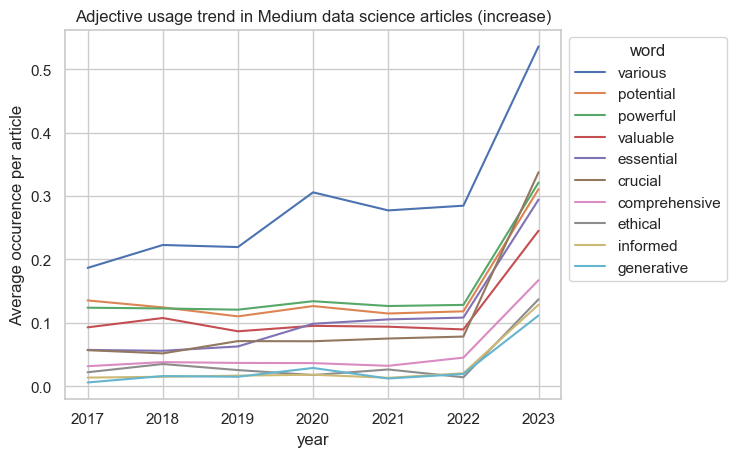

In [215]:
#Graph to show trend of top 10 adjectives that increased (filtered by score)

top_10_words_df = top_1000_words_pct_df.loc[top_1000_words_pct_df['% relative change'].str.contains('\+')].sort_values(by='score',ascending=False).head(10).iloc[:,1:8]
melted_df = pd.melt(top_10_words_df.reset_index(), id_vars=['word'], var_name='year', value_name='Score')
melted_df = melted_df.sort_values(by=['year','Score'],ascending=[True,False])

sns.set_style('whitegrid')
ax = sns.lineplot(data=melted_df,x='year',y='Score',hue='word')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Adjective usage trend in Medium data science articles (increase)')
plt.ylabel('Average occurence per article')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


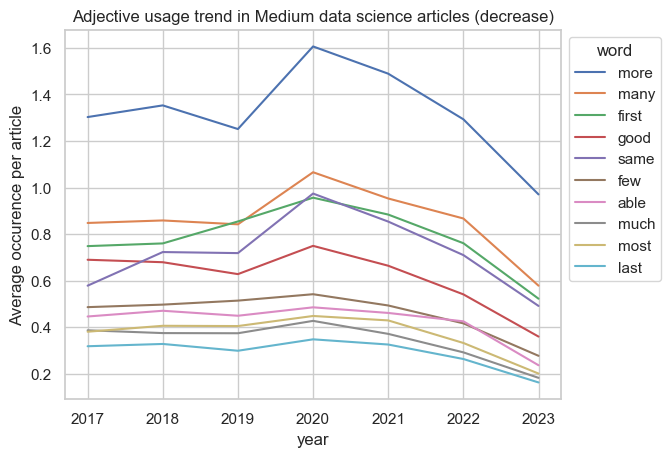

In [216]:
#Graph to show trend of top 10 adjectives that increased (filtered by score)

bottom_10_words_df = top_1000_words_pct_df.loc[top_1000_words_pct_df['% relative change'].str.contains('\-')].sort_values(by='score',ascending=False).head(10).iloc[:,1:8]

melted_df = pd.melt(bottom_10_words_df.reset_index(), id_vars=['word'], var_name='year', value_name='Score')
melted_df = melted_df.sort_values(by=['year','Score'],ascending=[True,False])


sns.set_style('whitegrid')
ax = sns.lineplot(data=melted_df,x='year',y='Score',hue='word')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Adjective usage trend in Medium data science articles (decrease)')
plt.ylabel('Average occurence per article')
plt.show()